Let's start by loading the necessary libraries, and setting some configuration options for reproducibility and visualization.

In [1]:
# %%
#Import top level libraries, including the deepvelo package
import numpy as np
import scvelo as scv
import torch

from deepvelo.utils import velocity, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

# set options for for visualization and verbosity
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)  # for beautified visualization

%load_ext autoreload
%autoreload 2


Using backend: pytorch
/h/hmaan/miniconda3/envs/dvelo_py_38/lib/python3.8/site-packages/deepvelo/utils/plot.py:5: DeprecationWarning: deepvelo.utils.plot is deprecated. Please use deepvelo.plot.plot instead.
  warnings.warn(


We're going to be using the Dentate Gyrus neurogenesis data from [La Manno et al. (2018)](https://doi.org/10.1038/s41586-018-0414-6) in this example. Start by loading and preprocessing the data.

In [2]:
adata = scv.datasets.dentategyrus_lamanno()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:28) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Now we're going to configure the DeepVelo model and name the experiment - we'll just call it DeepVelo for now. We're also going to empirically set the spliced correlation objective based on the data - this is recommended for best performance.

In [3]:
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}} # Automatic setting of the spliced correlation objective
}
configs = update_dict(Constants.default_configs, configs)


The ratio of spliced reads is 75.4% (between 70% and 85%). Suggest using coeff_s 0.75.


Now we can call the velocity and train methods to fit the model to the data. 

In [4]:
# initial velocity
velocity(adata, mask_zero=False)
trainer = train(adata, configs)

computing velocities
    finished (0:00:09) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Config Warning: Set to use GPU, but GPU version of DGL is not installed. Reset to use CPU instead.
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([18213, 2000])


INFO:trainer:    epoch          : 1
INFO:trainer:    time:          : 29.96326780319214
INFO:trainer:    loss           : 80684.3046875
INFO:trainer:    mse            : 0.9424933791160583
INFO:trainer:    epoch          : 2
INFO:trainer:    time:          : 29.954503774642944
INFO:trainer:    loss           : 16099.951171875
INFO:trainer:    mse            : 0.648495078086853
INFO:trainer:    epoch          : 3
INFO:trainer:    time:          : 29.717572450637817
INFO:trainer:    loss           : 9191.6279296875
INFO:trainer:    mse            : 0.6198586225509644
INFO:trainer:    epoch          : 4
INFO:trainer:    time:          : 29.664661645889282
INFO:trainer:    loss           : 6672.2099609375
INFO:trainer:    mse            : 0.6180260181427002
INFO:trainer:    epoch          : 5
INFO:trainer:    time:          : 31.579320192337036
INFO:trainer:    loss           : 5399.75439453125
INFO:trainer:    mse            : 0.6397780776023865
INFO:trainer:    epoch          : 6
INFO:tr

INFO:trainer:    loss           : 1804.290283203125
INFO:trainer:    mse            : 0.23960994184017181
INFO:trainer:    epoch          : 44
INFO:trainer:    time:          : 29.47594451904297
INFO:trainer:    loss           : 1796.568115234375
INFO:trainer:    mse            : 0.23961703479290009
INFO:trainer:    epoch          : 45
INFO:trainer:    time:          : 30.53779125213623
INFO:trainer:    loss           : 1791.1025390625
INFO:trainer:    mse            : 0.2359418272972107
INFO:trainer:    epoch          : 46
INFO:trainer:    time:          : 29.668327569961548
INFO:trainer:    loss           : 1777.1358642578125
INFO:trainer:    mse            : 0.234676793217659
INFO:trainer:    epoch          : 47
INFO:trainer:    time:          : 27.88861107826233
INFO:trainer:    loss           : 1771.228515625
INFO:trainer:    mse            : 0.22960108518600464
INFO:trainer:    epoch          : 48
INFO:trainer:    time:          : 27.988197803497314
INFO:trainer:    loss         

INFO:trainer:    loss           : 1632.7591552734375
INFO:trainer:    mse            : 0.18067723512649536
INFO:trainer:    epoch          : 86
INFO:trainer:    time:          : 28.316566467285156
INFO:trainer:    loss           : 1636.3070068359375
INFO:trainer:    mse            : 0.1824195832014084
INFO:trainer:    epoch          : 87
INFO:trainer:    time:          : 28.967862129211426
INFO:trainer:    loss           : 1631.428955078125
INFO:trainer:    mse            : 0.18171441555023193
INFO:trainer:    epoch          : 88
INFO:trainer:    time:          : 32.411577224731445
INFO:trainer:    loss           : 1630.986572265625
INFO:trainer:    mse            : 0.18051208555698395
INFO:trainer:    epoch          : 89
INFO:trainer:    time:          : 30.405394315719604
INFO:trainer:    loss           : 1627.5289306640625
INFO:trainer:    mse            : 0.18179184198379517
INFO:trainer:    epoch          : 90
INFO:trainer:    time:          : 29.0878164768219
INFO:trainer:    los

confidence mse shape: (18213, 2000)
confidence mse stats: max 1110.5377197265625, min 0.0, mean 0.26669085025787354, std 3.563610315322876
confidence corr shape: (2000,)
confidence corr stats: max 0.8994786143302917, min -0.1158176138997078, mean 0.4460125267505646, std 0.14505398273468018
velo_mat shape: (18213, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


Now that the velocity calculation is complete, we can visualize the results. We'll start by visualizing the velocity field in the embedding space.

computing velocity graph (using 8/32 cores)


/h/hmaan/miniconda3/envs/dvelo_py_38/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:02:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:09) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


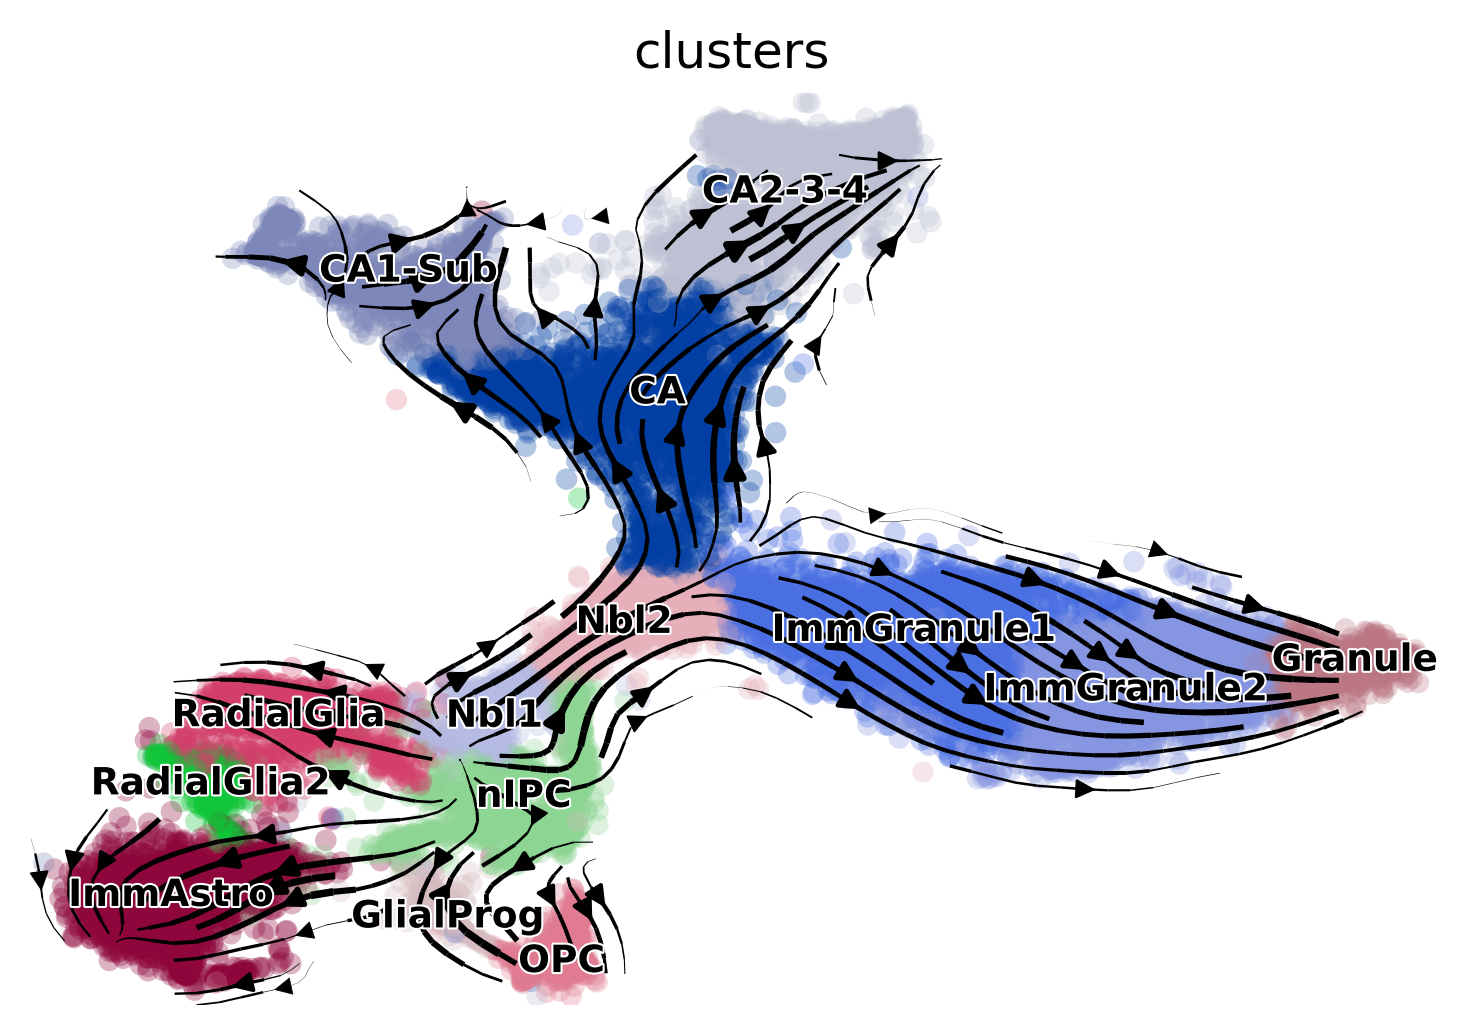

In [5]:
# velocity plot
scv.tl.velocity_graph(adata, n_jobs=8)
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="clusters",
    legend_fontsize=9,
    dpi=150,  # increase dpi for higher resolution
)


We can further visualize the pseudotime estimated based on the velocity field, and plot this in the embedding space.

computing terminal states
    identified 3 regions of root cells and 4 regions of end points .
    finished (0:00:05) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


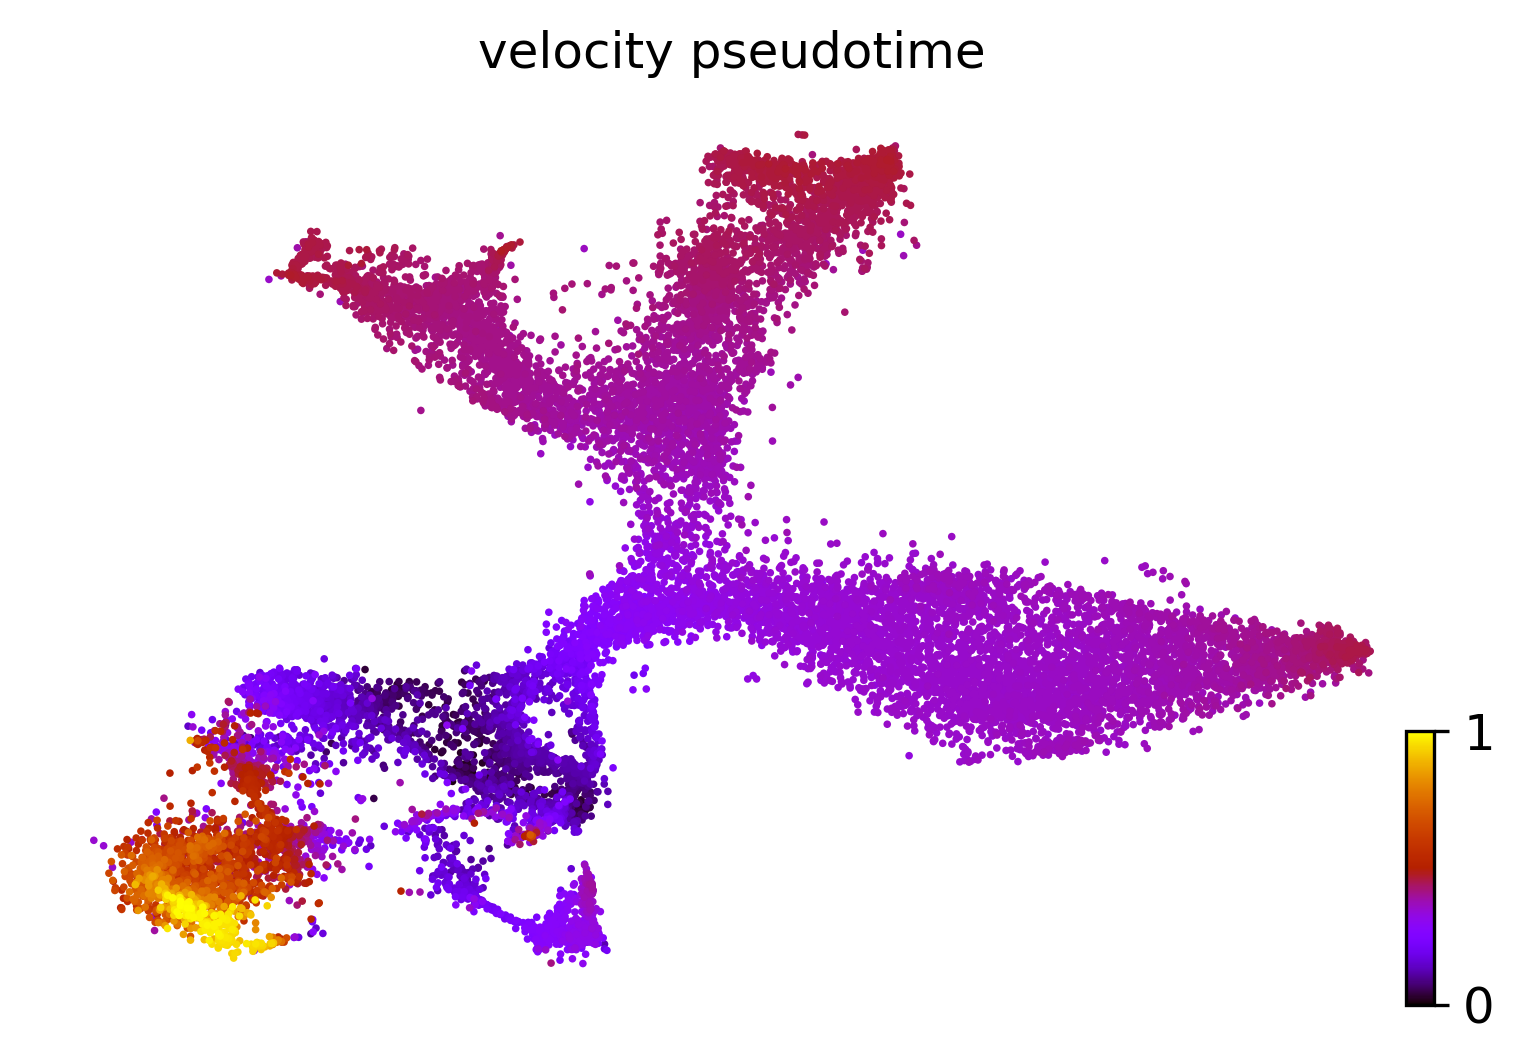

In [6]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(
    adata,
    color="velocity_pseudotime",
    cmap="gnuplot",
    dpi=150,
)

There are a number of other visualizations and analyses that can be performed - please see the rest of the examples from the paper.
